In [95]:
# pip install --user scikit-image

In [148]:
import glob

import tensorflow as tf
import os
import random
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import json

import tensorflow as tf
import cv2
import numpy as np

from tensorflow import keras

from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from skimage.io import imread, imshow
from skimage.transform import resize
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers

In [134]:
data_dir = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics"

In [98]:
datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255)

In [99]:
# Чтобы загрузчик извлёк данные из папки, вызовем функцию flow_from_directory() (англ. «поток из директории»):
train_datagen_flow = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345
)

Found 567 images belonging to 3 classes.


In [100]:
# англ. индексы классов
print(train_datagen_flow.class_indices)

{'.git': 0, '.idea': 1, 'base': 2}


In [101]:
# the first image
print(next(train_datagen_flow)[0][0])

[[[0.1137255  0.1137255  0.1137255 ]
  [0.11764707 0.11764707 0.11764707]
  [0.10196079 0.10196079 0.10196079]
  ...
  [0.14901961 0.14901961 0.14901961]
  [0.13725491 0.15686275 0.14117648]
  [0.19215688 0.18823531 0.17254902]]

 [[0.1137255  0.1137255  0.1137255 ]
  [0.09019608 0.09019608 0.09019608]
  [0.09411766 0.09411766 0.09411766]
  ...
  [0.14117648 0.14117648 0.14117648]
  [0.15294118 0.15686275 0.13333334]
  [0.23529413 0.21568629 0.19215688]]

 [[0.08627451 0.08627451 0.08627451]
  [0.09803922 0.09803922 0.09803922]
  [0.09411766 0.09411766 0.09411766]
  ...
  [0.12941177 0.13333334 0.1137255 ]
  [0.20392159 0.19215688 0.16470589]
  [0.227451   0.21568629 0.18823531]]

 ...

 [[0.3803922  0.3803922  0.34901962]
  [0.38431376 0.3803922  0.36078432]
  [0.36862746 0.3647059  0.35686275]
  ...
  [0.3372549  0.31764707 0.29411766]
  [0.29411766 0.26666668 0.24313727]
  [0.29803923 0.27058825 0.24705884]]

 [[0.36862746 0.3647059  0.35686275]
  [0.3529412  0.34901962 0.34117648]


In [102]:
val_datagen_flow = datagen.flow_from_directory(data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345
)

Found 189 images belonging to 3 classes.


In [103]:
print(val_datagen_flow.class_indices)

{'.git': 0, '.idea': 1, 'base': 2}


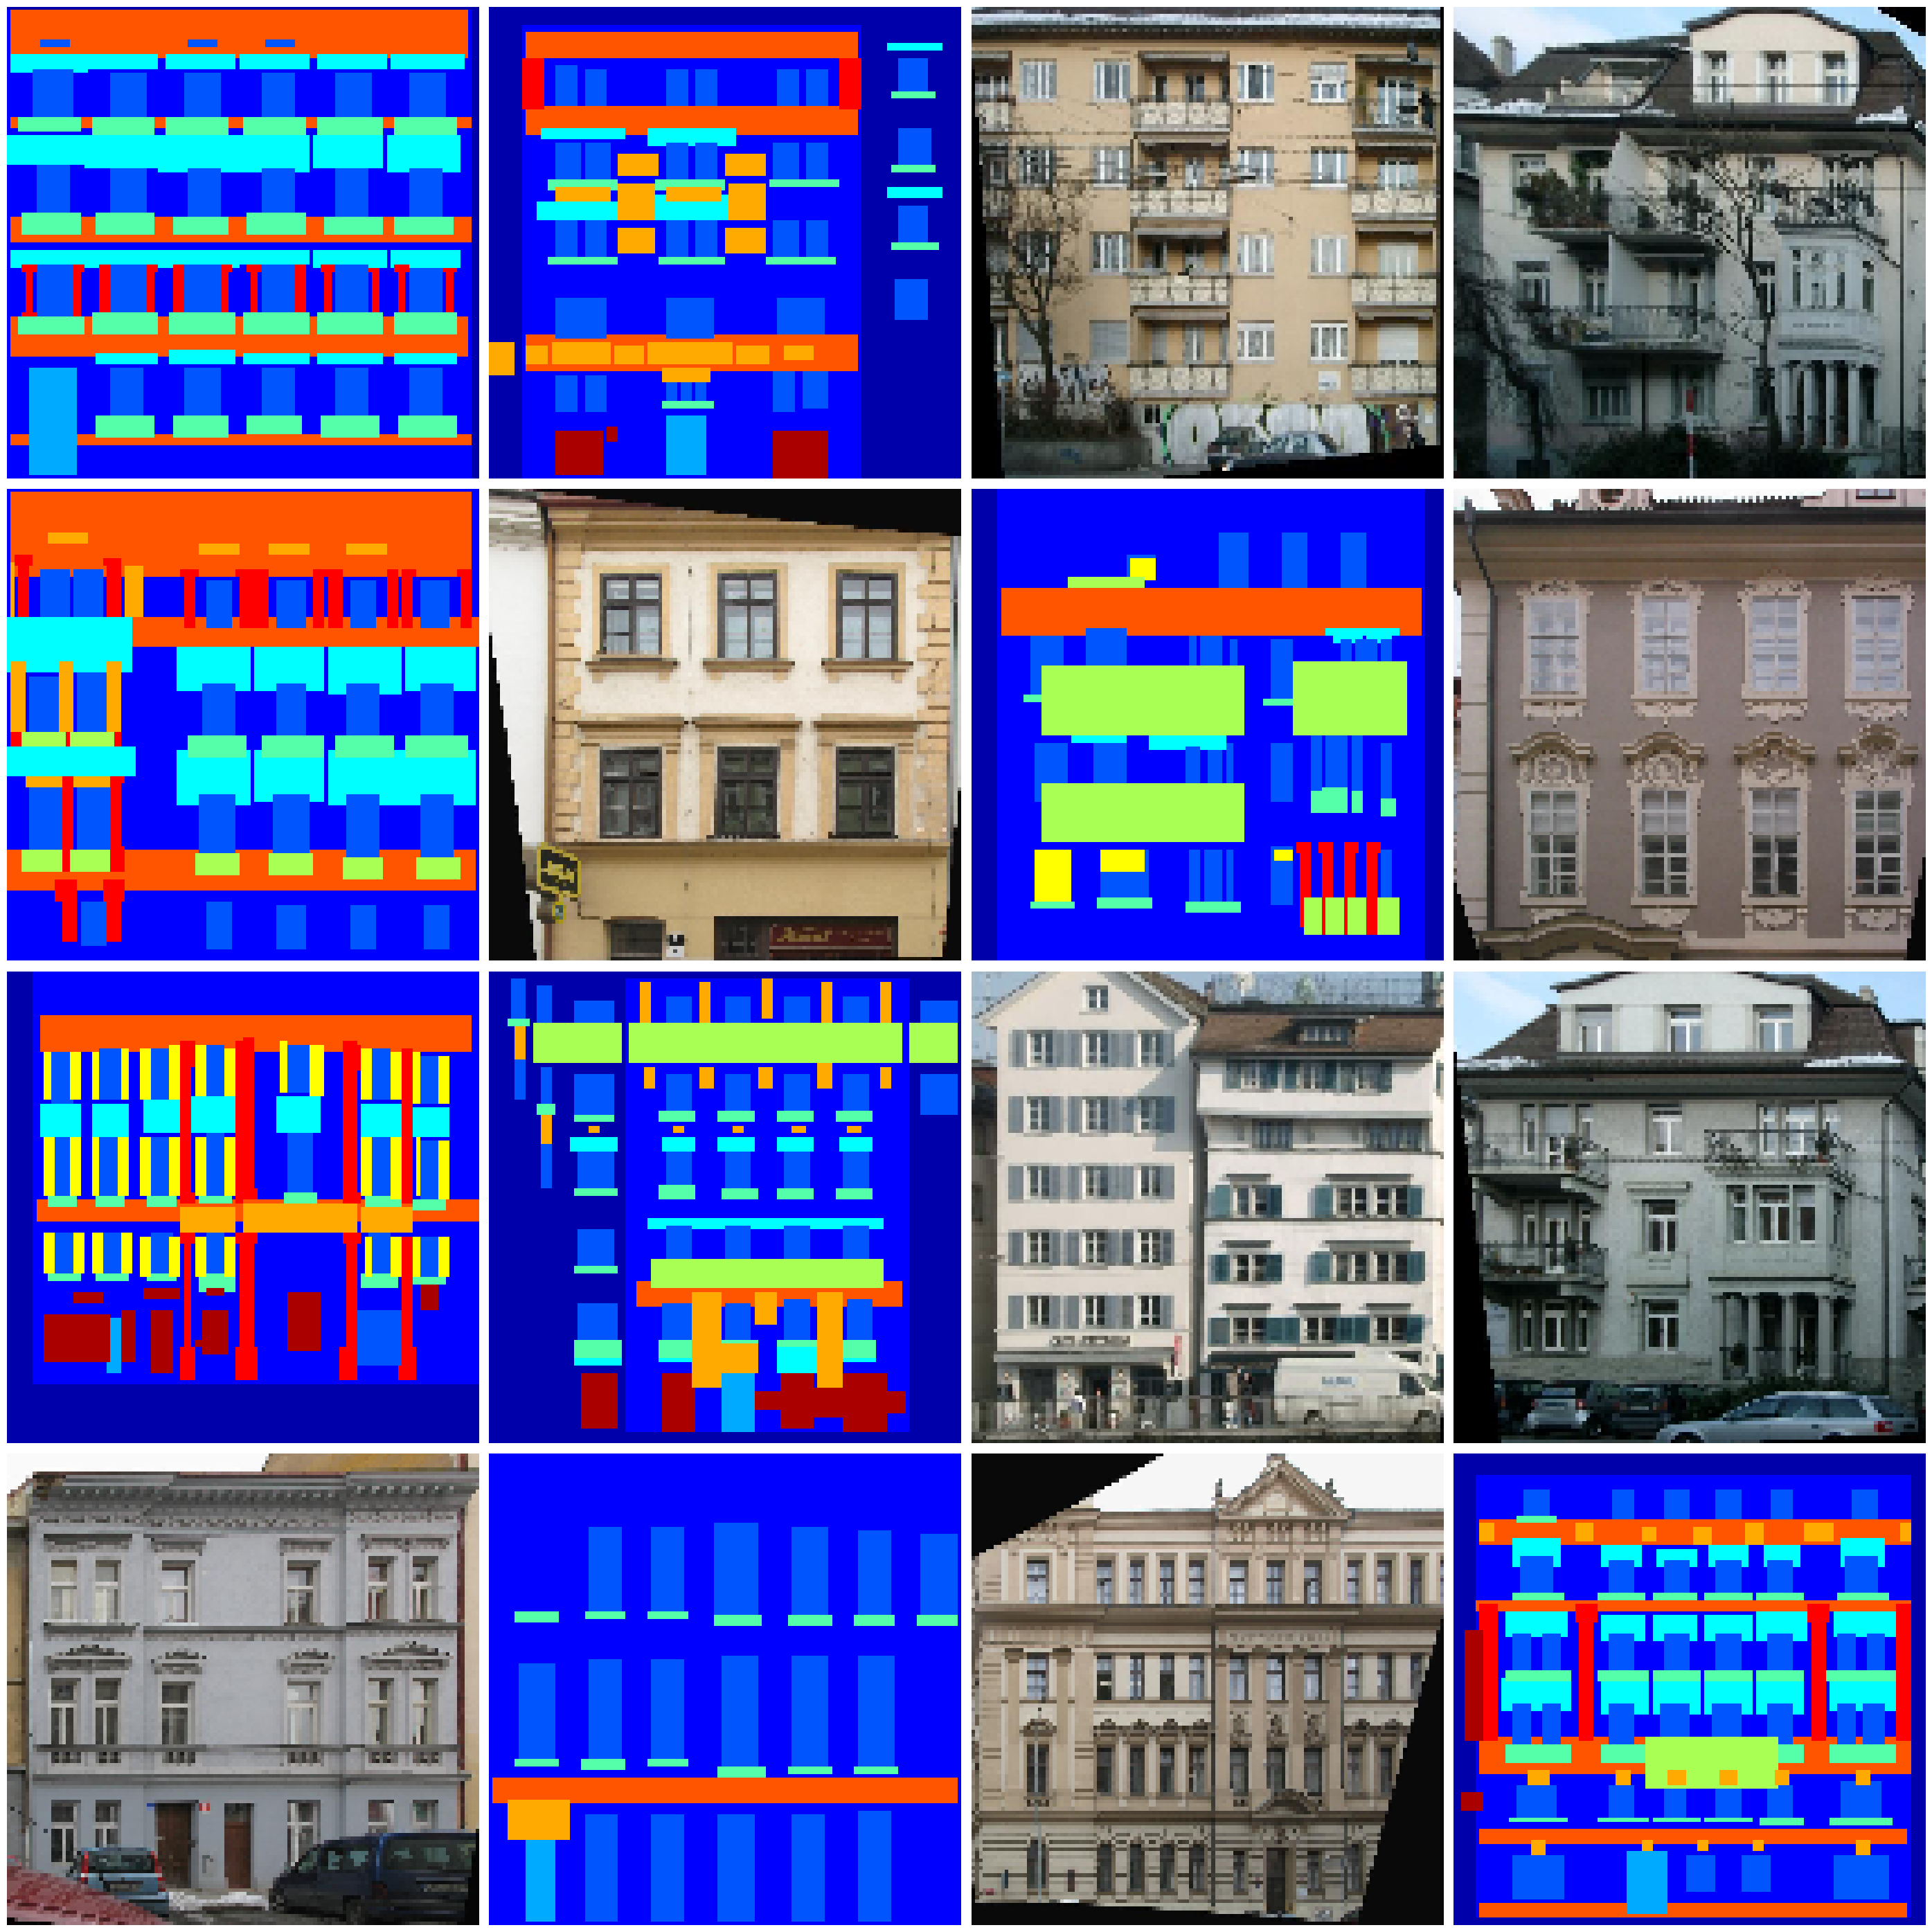

In [104]:
features, target = next(train_datagen_flow)

# to display grid of images
fig = plt.figure(figsize=(28, 28))
for i in range(len(features)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.axis('off')

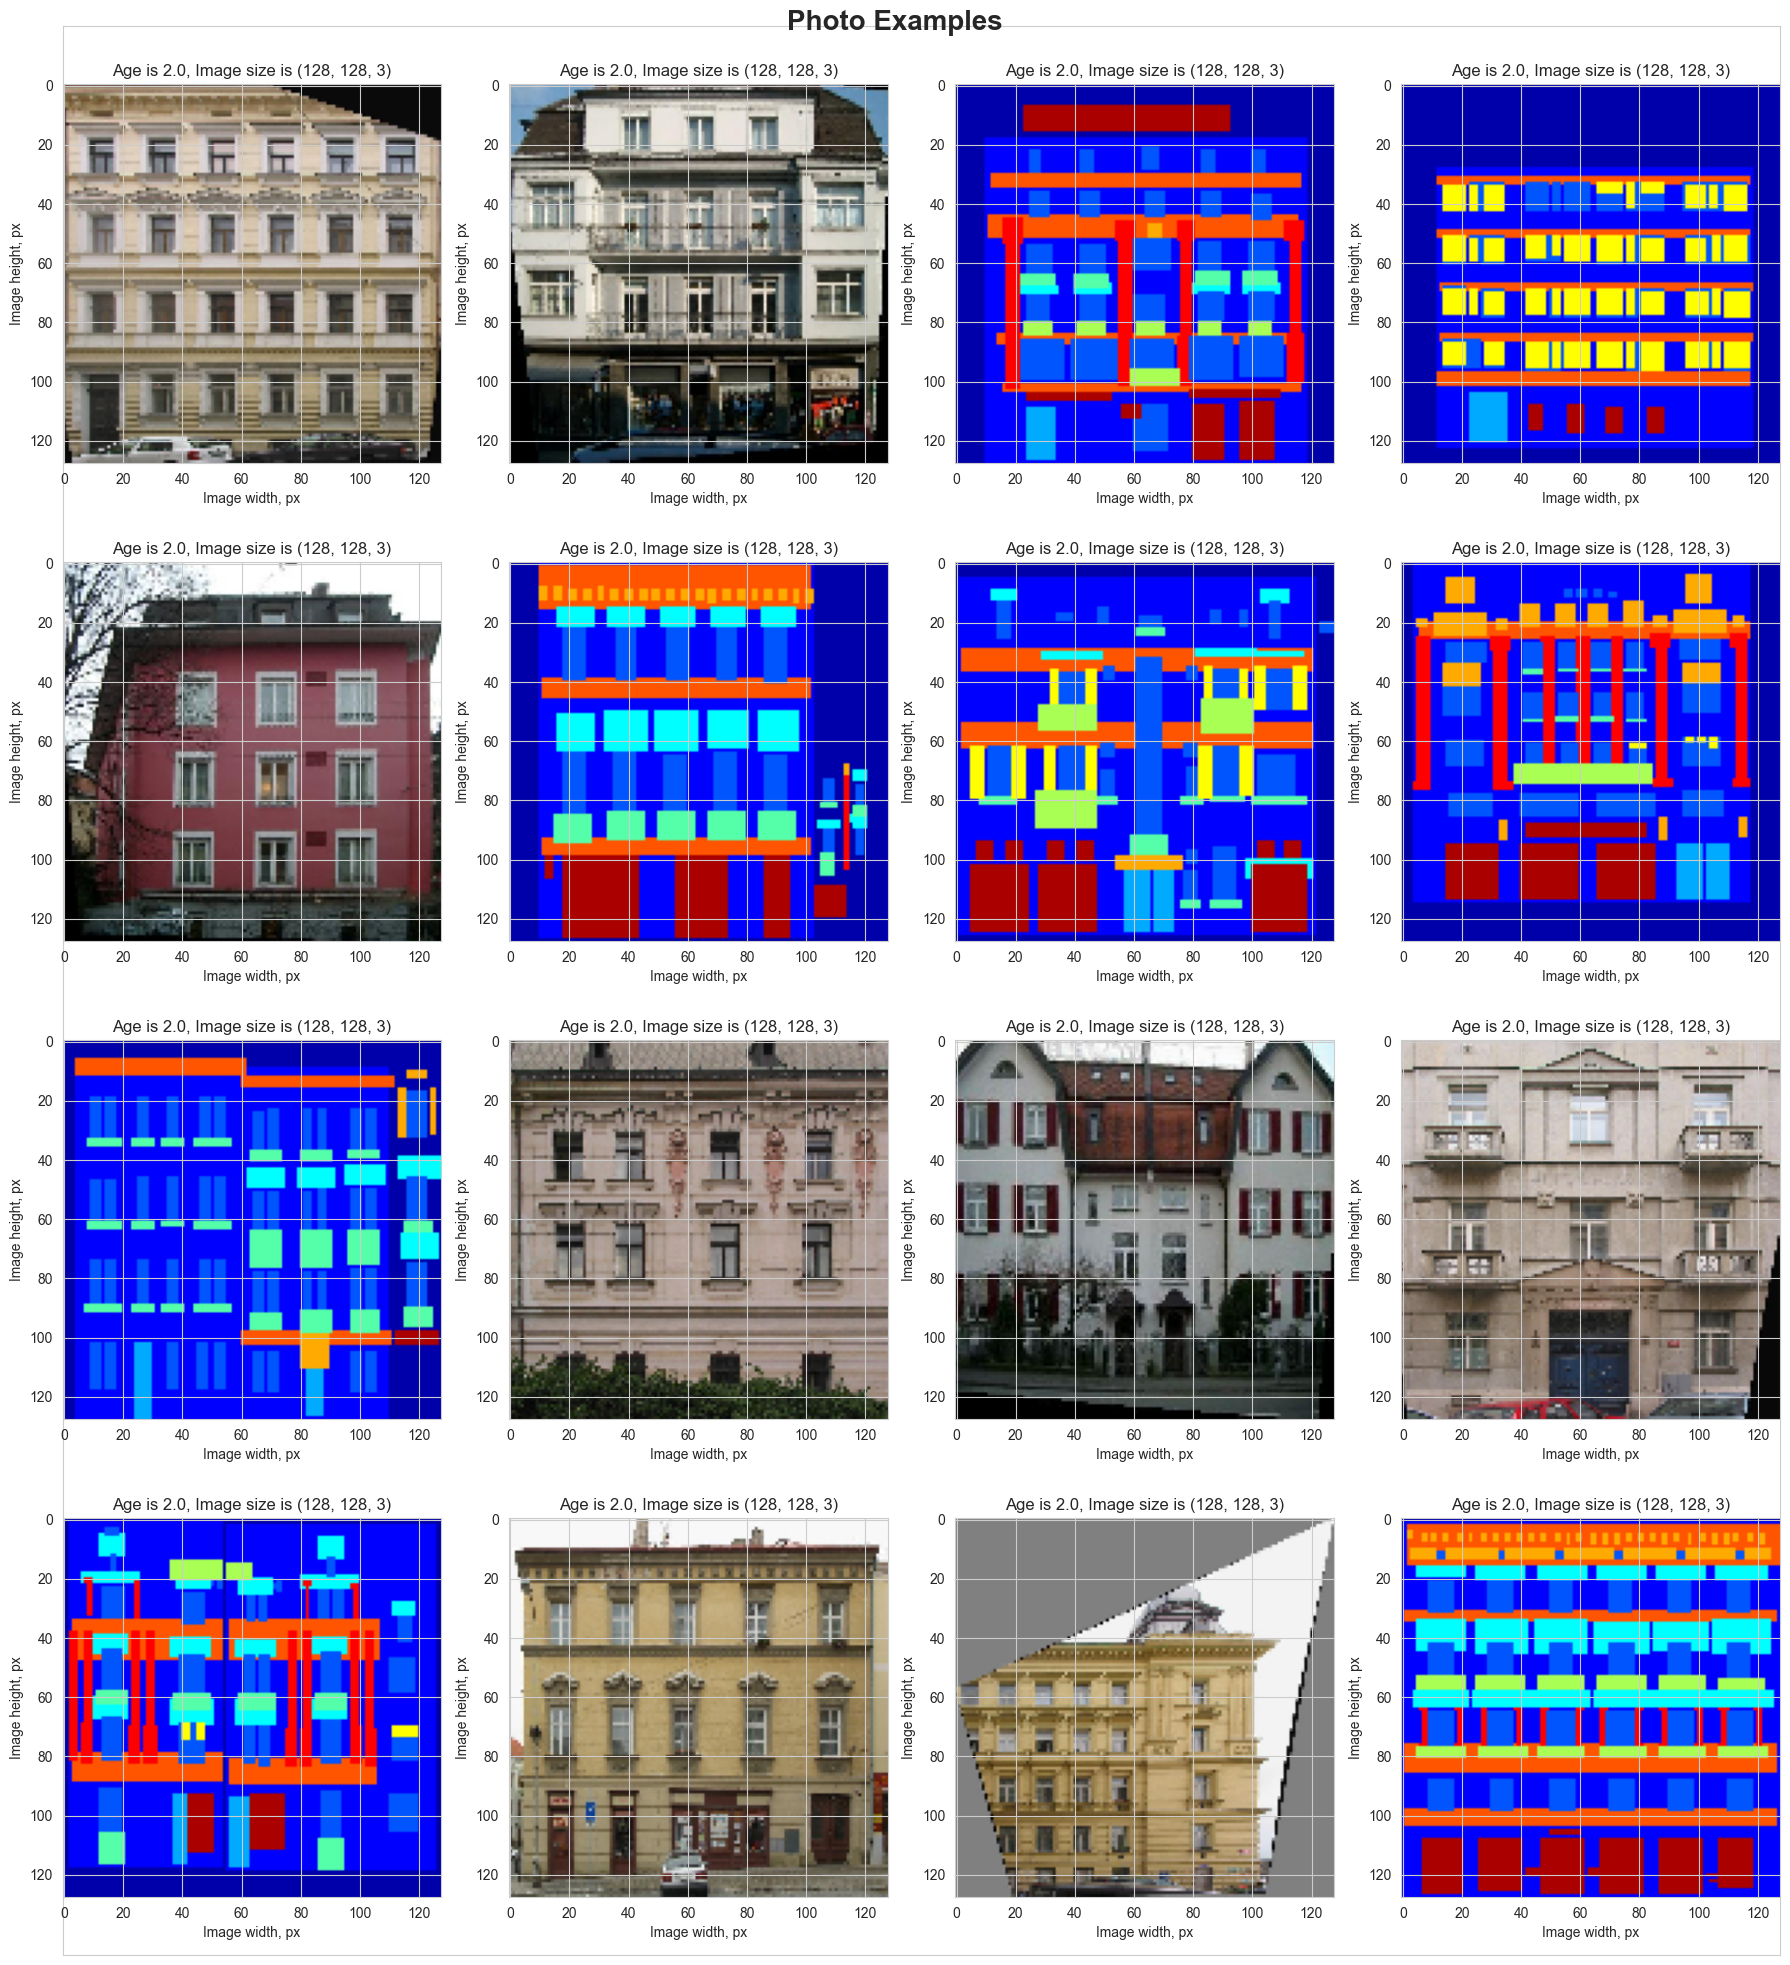

In [105]:
features, target = next(train_datagen_flow)

# выводим 16 изображений

fig = plt.figure(figsize=(18, 20))
plt.suptitle('Photo Examples', fontsize=20, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()
    plt.title('Age is {}, Image size is {}'.format(target[i], features[i].shape), loc='center')
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')
plt.show();

### Color Mapping

**Создадим словарь 'color_mapping', который содержит отображение цветов в числовые значения.**

Ключи словаря - это цвета в формате RGB (каждая цифра от 0 до 255), которые представлены в виде кортежа из трех чисел. Значения словаря - это числовые метки, которые соответствуют определенной категории (фон, фасад, окна, двери, карниз, подоконник, балкон, жалюзи, декоративные элементы, молдинги, столбы и магазины).

Таким образом, при обработке изображения с помощью этого словаря, программа будет проверять каждый пиксель на соответствие цвету из словаря и присваивать ему числовое значение, соответствующее соответствующей категории.

* 1 background 1
* 2 facade 2
* 3 window 10
* 4 door 5
* 5 cornice 11
* 6 sill 3
* 7 balcony 4
* 8 blind 6
* 9 deco 8
* 10 molding 7
* 11 pillar 12
* 12 shop 9

In [106]:
color_mapping = {
    (0, 0, 0): 1,    # background
    (255, 0, 0): 2,  # facade
    (0, 255, 0): 10, # window
    (0, 0, 255): 5,  # door
    (255, 255, 0): 11, # cornice
    (255, 128, 0): 3, # sill
    (128, 255, 0): 4, # balcony
    (255, 0, 255): 6, # blind
    (128, 0, 255): 8, # deco
    (0, 255, 255): 7, # molding
    (255, 0, 128): 12, # pillar
    (255, 255, 255): 9 # shop
}

Теперь напишем код, который загружает маску (изображение, на котором каждый цвет соответствует определенной категории объектов) и создает пустой массив для меток классов. Затем он проходит в цикле по каждому пикселю маски и присваивает соответствующую метку класса на основе значения цвета.

Если значение цвета не соответствует ни одному цвету из словаря color_mapping, то метке класса присваивается значение 0 (предполагается, что это фон). Результатом работы этого кода является массив labels, содержащий метки классов для каждого пикселя маски.

In [107]:
# пример одной маски
mask = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0298.png")

# Create an empty array for the class labels
labels = np.zeros(mask.shape[:2], dtype=np.uint8)

# Loop over the pixels and assign the corresponding class label based on the color value
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        color = tuple(mask[i, j])
        if color in color_mapping:
            labels[i, j] = color_mapping[color]

In [108]:
mask

array([[[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       ...,

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

In [109]:
CLASSES = 12

In [110]:
# раметка данных, создание меток
for png_file in glob.glob(f"{data_dir}*.png"):
    # Load the mask image
    mask = cv2.imread(png_file)

    # Create an empty array for the class labels
    labels = np.zeros(mask.shape[:2], dtype=np.uint8)

    # Loop over the pixels and assign the corresponding class label based on the color value
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            color = tuple(mask[i, j])
            if color in color_mapping:
                labels[i, j] = color_mapping[color]

    mask_file = png_file.replace(".png", "_mask.png")
    cv2.imwrite(mask_file, labels)

In [111]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)

In [112]:
import colorsys
import webcolors

In [113]:
# определим, какой цвет за что отвечает
COLORS = []
for color in color_mapping:
    rgb = color
    css3_name = None
    try:
        css3_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        pass
    if css3_name:
        COLORS.append(css3_name)

In [124]:
len(COLORS)

8

In [125]:
COLORS

['black', 'red', 'lime', 'blue', 'yellow', 'magenta', 'cyan', 'white']

In [126]:
# определим, какой класс представлен каким цветом. Нас интересуют фасады под классом 2
class_color_mapping = {}
for color in COLORS:
    for rgb, class_label in color_mapping.items():
        if webcolors.name_to_rgb(color) == rgb:
            class_color_mapping[color] = class_label
            break

In [127]:
class_color_mapping

{'black': 1,
 'red': 2,
 'lime': 10,
 'blue': 5,
 'yellow': 11,
 'magenta': 6,
 'cyan': 7,
 'white': 9}

### Видим, что из 12 классов у нас размечены только 8 классов. В частности, фасады (класс 2) под красным цветом.

## Конвейер данных Tensorflow

In [145]:
image_path = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\*.jpg"
mask_path = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\*.png"

In [146]:
type(image_path)

str

In [147]:
image_path

'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\*.jpg'

In [128]:
batch_size = 16
img_size = (128, 128)
CLASSES = len(COLORS) # 8 classes
OUTPUT_SIZE = (1080, 1920)

base_dir = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base"

In [139]:
# оригинальные картинки
image = sorted(
    [
        os.path.join(data_dir, filename)
        for filename in os.listdir(base_dir)
        if filename.endswith('.jpg')
    ]
)

# их маски
mask = sorted(
    [
        os.path.join(data_dir, filename)
        for filename in os.listdir(base_dir)
        if filename.endswith('.png')
    ]
)

In [130]:
print('Количество пакетов (батчей):', len(image))

Количество пакетов (батчей): 378


In [131]:
for image, mask in zip(image[:10], mask[:10]):
    print(image, ' | ', mask)

C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0001.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0001.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0002.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0002.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0003.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0003.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0004.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0004.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0005.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0005.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0006.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0006.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0007.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0007.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0008.j

## Векторизуем данные и готовим подвыборки

In [138]:
class BuildingAnalytics(keras.utils.Sequence):
    """
    Helper class to iterate over the dataset.

    """
    def __init__(self, batch_size, img_size, image, mask):
        self.batch_size = batch_size
        self.img_size = img_size
        self.image = image
        self.mask = mask

    def __len__(self):
        return len(self.mask) // self.batch_size

    def __getitem__(self, idx):
        """
        :param idx: Number of batches.
        :return: Tuple (image, mask) to the batch # idx
        """
        i = idx * self.batch_size
        batch_image = self.image[i : i + self.batch_size]
        batch_mask = self.mask[i : i + self.batch_size]
        # a placeholder for the entire batch
        x = np.zeros((self.batch_size,) + self.img_size + (8, ), dtype='float32')

        for j, path in enumerate(batch_image):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1, ), dtype='unit8')

        for j, path in enumerate(batch_mask):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y